In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

import gala as ga

import sys
sys.path.append("../src")
from kicks import integrate_orbits_with_kicks

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [3]:
galcen_frame = coord.Galactocentric()

In [4]:
sun_w0 = gd.PhaseSpacePosition(
    pos=[-8.2, 0, 0.02] * u.kpc,
    vel=galcen_frame.galcen_v_sun
)

In [13]:
c = coord.SkyCoord(ra="17:51:40.2082", dec="-29:53:26.502", unit=(u.hourangle, u.degree))
cosdec = np.cos(c.dec) 

w0s = []

for rv in np.linspace(-100, 100, 5):
    c = coord.SkyCoord(
        ra="17:51:40.2082",
        dec="-29:53:26.502",
        unit=(u.hourangle, u.degree),
        distance=1.58*u.kpc,
        pm_ra_cosdec=-4.36*u.mas/u.yr,# * cosdec,
        pm_dec=3.06*u.mas/u.yr,
        radial_velocity=rv*u.km/u.s
    )

    w0 = gd.PhaseSpacePosition(c.transform_to(galcen_frame).data)
    w0s.append(w0)
    
w0s = gd.combine(w0s)

In [86]:
orbits

<Orbit cartesian, dim=3, shape=(4001, 5)>

In [6]:
pot = gp.MilkyWayPotential()
orbits = pot.integrate_orbit(w0s, dt=4*u.Gyr / 4000, n_steps=4000)
sun_orbit = pot.integrate_orbit(sun_w0, t=orbits.t)

In [14]:
no_kicks = integrate_orbits_with_kicks(w0s, dt=4*u.Gyr / 4000, n_steps=4000)

In [17]:
from scipy.stats import maxwell

In [208]:
import gala as ga
import numpy as np
import astropy.coordinates as coord
import astropy.units as u
from scipy.stats import maxwell


class Kick():
    """Represents a supernova kick: magnitudes of kicks in particular directions"""

    def __init__(self, magnitude, phi, theta, t):
        """
        Parameters
        ----------
        magnitude : `float/array`
            Magnitude(s) of kicks corresponding to each object
        phi : `float/array`
            Magnitude(s) of kicks corresponding to each object
        theta : `float/array`
            Magnitude(s) of kicks corresponding to each object
        t : `float`
            Time at which the kick(s) occurred
        """
        self.magnitude = magnitude if isinstance(magnitude, u.quantity.Quantity) else magnitude * u.km / u.s
        self.phi = phi if isinstance(phi, u.quantity.Quantity) else phi * u.rad
        self.theta = theta if isinstance(theta, u.quantity.Quantity) else theta * u.rad
        self.t = t if isinstance(t, u.quantity.Quantity) else t * u.Gyr

    def __getitem__(self, slice_):
        if isinstance(slice_, np.ndarray) or isinstance(slice_, list):
            slice_ = (slice_,)

        try:
            slice_ = tuple(slice_)
        except TypeError:
            slice_ = (slice_,)

        return self.__class__(magnitude=self.magnitude[slice_],
                              phi=self.phi[slice_],
                              theta=self.theta[slice_],
                              t=self.t)

    def __repr__(self):
        if isinstance(self.magnitude.value, float):
            return "<Kick, magnitude={:1.2f}, phi={:1.2f}, theta={:1.2f}, time={:1.2f}>".format(self.magnitude, self.phi, self.theta)
        else:
            return "<Kick, n_objects={}>".format(len(self.magnitude))


def integrate_orbits_with_kicks(w0, potential=ga.potential.MilkyWayPotential(), kicks=None, kick_times=None,
                                maxwell_sigma=265 * u.km / u.s, same_angle=False, ret_kicks=False,
                                **integrate_kwargs):
    """Integrate PhaseSpacePosition in a potential with kicks that occur at certain times

    Parameters
    ----------
    potential : `ga.potential.PotentialBase`
        Potential in which you which to integrate the orbits
    w0 : `ga.dynamics.PhaseSpacePosition`, optional
        Initial phase space position, by default the MilkyWayPotential()
    kicks : `list`, optional
        List of None, or list of kick magnitudes or list of tuples with kick magnitudes and angles,
        by default None
    kick_times : `list`, optional
        Times at which kicks occur, by default None
    maxwell_sigma : `float`
        Sigma to use for the maxwellian for kick magnitudes
    same_angle : `boolean`
        Whether to use the same random kick angle for each individual orbit if several are provided
    ret_kicks : `boolean`
        Whether to return the kicks that were used in the evolution in addition to the orbits

    Returns
    -------
    full_orbits : `ga.orbit.Orbit`
        Orbits that have been integrated
    """
    # if there are no kicks then just integrate the whole thing
    if kicks is None and kick_times is None:
        return potential.integrate_orbit(w0, **integrate_kwargs)

    # otherwise make sure that both are there
    elif kick_times is None:
        raise ValueError("Kick times must be specified if kicks are used")

    # integrate using the kicks
    else:
        # create a list of None is nothing is given
        if kicks is None:
            kicks = [None for _ in range(len(kick_times))]

        # work out what the timesteps would be without kicks
        timesteps = ga.integrate.parse_time_specification(units=[u.s], **integrate_kwargs) * u.s

        # start the cursor at the smallest timestep
        time_cursor = timesteps[0]
        current_w0 = w0

        if ret_kicks:
            drawn_kicks = []

        # keep track of the orbit data throughout
        data = []
        for kick, kick_time in zip(kicks, kick_times):
            # find the timesteps that occur before the kick
            matching_timesteps = timesteps[np.logical_and(timesteps >= time_cursor, timesteps < kick_time)]

            # integrate the orbit over these timesteps
            orbits = potential.integrate_orbit(current_w0, t=matching_timesteps)

            # save the orbit data
            data.append(orbits.data)

            # adjust the time
            time_cursor = kick_time

            # get new PhaseSpacePosition(s)
            current_w0 = orbits[-1]

            if isinstance(kick, tuple):
                magnitude, phi, theta = kick
            else:
                # if there's only one orbit
                if current_w0.shape == ():
                    magnitude = kick if kick is not None\
                        else maxwell(maxwell_sigma).rvs() * maxwell_sigma.unit
                    phi = np.random.uniform(0, 2 * np.pi) * u.rad
                    theta = np.random.uniform(-np.pi / 2, np.pi / 2) * u.rad
                else:
                    magnitude = kick if kick is not None else\
                        maxwell(scale=maxwell_sigma).rvs(current_w0.shape[0]) * maxwell_sigma.unit

                    if same_angle:
                        phi_0 = np.random.uniform(0, 2 * np.pi)
                        theta_0 = np.random.uniform(-np.pi / 2, np.pi / 2)
                        phi = np.repeat(phi_0, repeats=current_w0.shape[0]) * u.rad
                        theta = np.repeat(theta_0, repeats=current_w0.shape[0]) * u.rad
                    else:
                        phi = np.random.uniform(0, 2 * np.pi, size=current_w0.shape[0]) * u.rad
                        theta = np.random.uniform(-np.pi / 2, np.pi / 2, size=current_w0.shape[0]) * u.rad

            if ret_kicks:
                drawn_kicks.append(Kick(magnitude=magnitude, phi=phi, theta=theta, t=kick_time))

            d_x = magnitude * np.cos(phi) * np.sin(theta)
            d_y = magnitude * np.sin(phi) * np.sin(theta)
            d_z = magnitude * np.cos(theta)

            kick_differential = coord.CartesianDifferential(d_x, d_y, d_z)

            current_w0 = ga.dynamics.PhaseSpacePosition(pos=current_w0.pos,
                                                        vel=current_w0.vel + kick_differential,
                                                        frame=current_w0.frame)

        if time_cursor < timesteps[-1]:
            matching_timesteps = timesteps[timesteps >= time_cursor]
            orbits = potential.integrate_orbit(current_w0, t=matching_timesteps)
            data.append(orbits.data)

        data = coord.concatenate_representations(data)
        full_orbits = ga.dynamics.orbit.Orbit(pos=data.without_differentials(),
                                              vel=data.differentials["s"],
                                              t=timesteps.to(u.Myr))

        if ret_kicks:
            return full_orbits, drawn_kicks if len(drawn_kicks) > 1 else drawn_kicks[0]
        else:
            return full_orbits


In [211]:
# kicks = [(45 * u.km / u.s, 0 * u.deg, -90 * u.deg)]
kicks = [45 * u.km / u.s]
kick_times = [0.5 * u.Gyr]
with_kicks, test = integrate_orbits_with_kicks(w0s, kicks=None, kick_times=kick_times, dt=4*u.Gyr / 4000, n_steps=4000, same_angle=True, ret_kicks=True)

In [204]:
import scipy

In [205]:
scipy.__version__

'1.7.3'

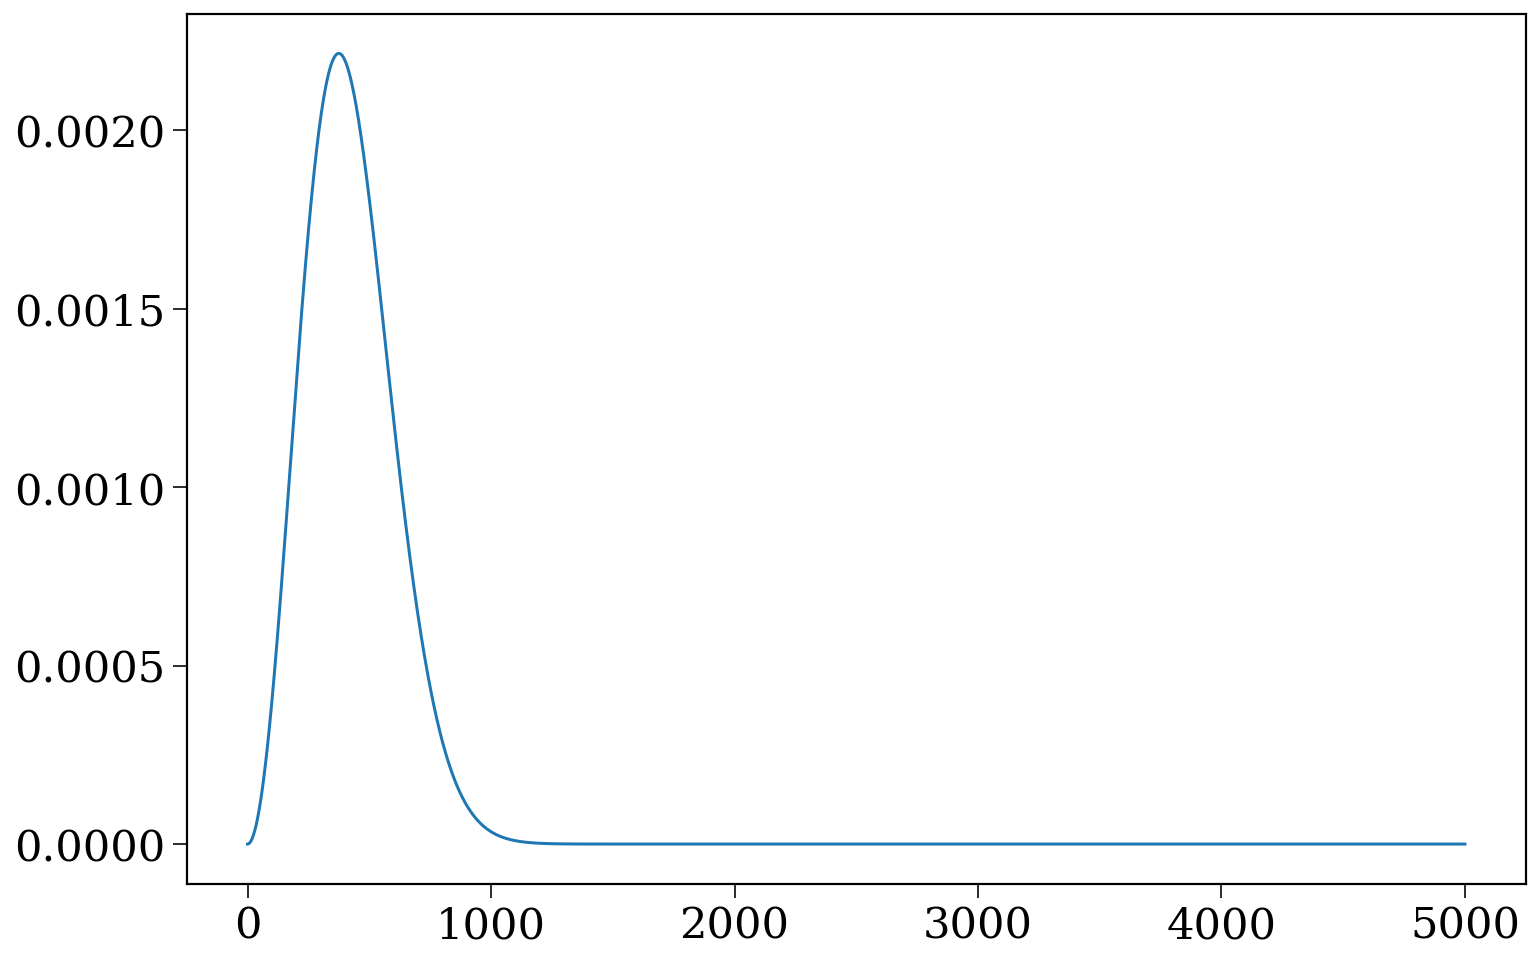

In [210]:
from scipy.stats import maxwell

v_range = np.linspace(0, 5000, 10000)
plt.plot(v_range, maxwell(scale=265).pdf(v_range))

In [196]:
test.magnitude

<Quantity [266.60173486, 268.01071191, 265.88344517, 266.00959398,
           265.75598953] km / s>

In [189]:
test = w0s[0]

In [104]:
orbit = integrate_orbits_with_kicks(pot, test, kicks=[None], kick_times=kick_times, dt=4 * u.Gyr / 4000, n_steps=40000)

In [51]:
orbit = pot.integrate_orbit(test, dt=4 * u.Gyr / 4000, n_steps=40000)

(array([[0.00543496, 0.01210826, 0.00546936, 0.03071784, 0.01740563,
         0.01197067, 0.00877161, 0.00601973, 0.00299267, 0.        ],
        [0.00474699, 0.0157889 , 0.00736127, 0.03893908, 0.01324341,
         0.01007875, 0.00880601, 0.00849642, 0.00856522, 0.0068453 ],
        [0.00429981, 0.00825563, 0.01028514, 0.02975468, 0.01912555,
         0.01255544, 0.00818684, 0.00853082, 0.01272744, 0.01513533],
        [0.00622612, 0.00488458, 0.00632932, 0.02810356, 0.01888476,
         0.01520413, 0.01162669, 0.00928759, 0.01159229, 0.02796596],
        [0.00134154, 0.00739567, 0.0068797 , 0.0293075 , 0.02136145,
         0.01740563, 0.01850638, 0.0204327 , 0.03333212, 0.03911107],
        [0.00746447, 0.00505658, 0.00767086, 0.01905676, 0.013553  ,
         0.01506653, 0.01915995, 0.02294378, 0.03986783, 0.03570562],
        [0.00595094, 0.00402462, 0.00973477, 0.03044265, 0.02366615,
         0.01713044, 0.0112483 , 0.01004436, 0.01331221, 0.02851634],
        [0.00357744, 0.0045

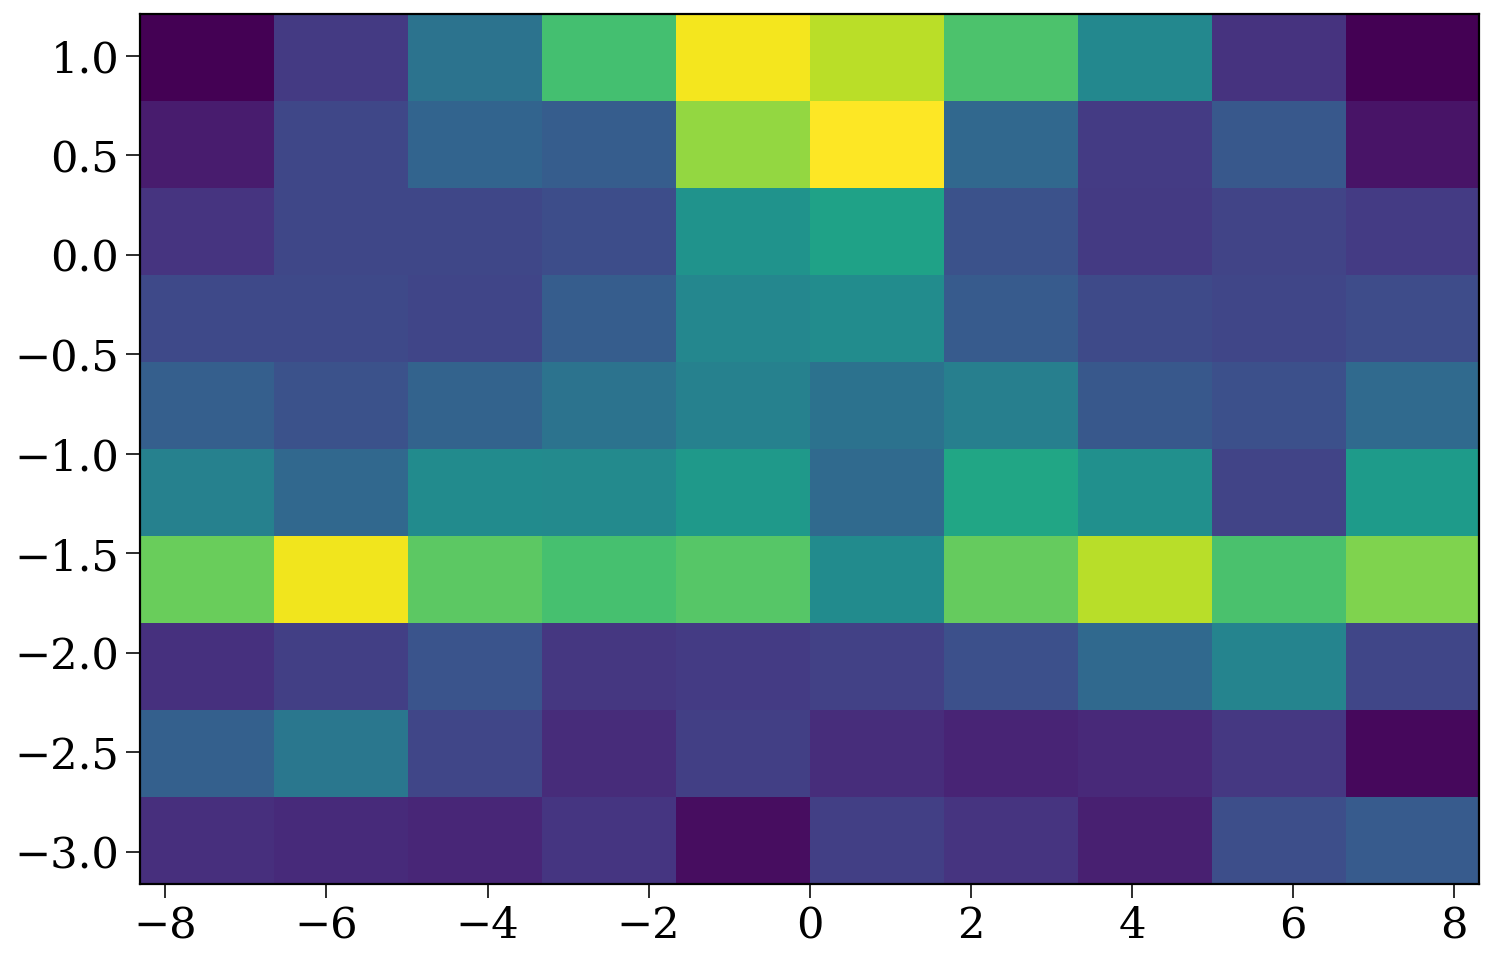

In [105]:
plt.hist2d(orbit.x.value, orbit.z.value, density=True)

In [29]:
orbit.x

<Quantity [-6.5427299 , -6.52388637, -6.49625241, ..., -5.32360618,
           -5.18897307, -5.04773347] kpc>

In [116]:
no_kicks[:, 0]

<Orbit cartesian, dim=3, shape=(4001,)>

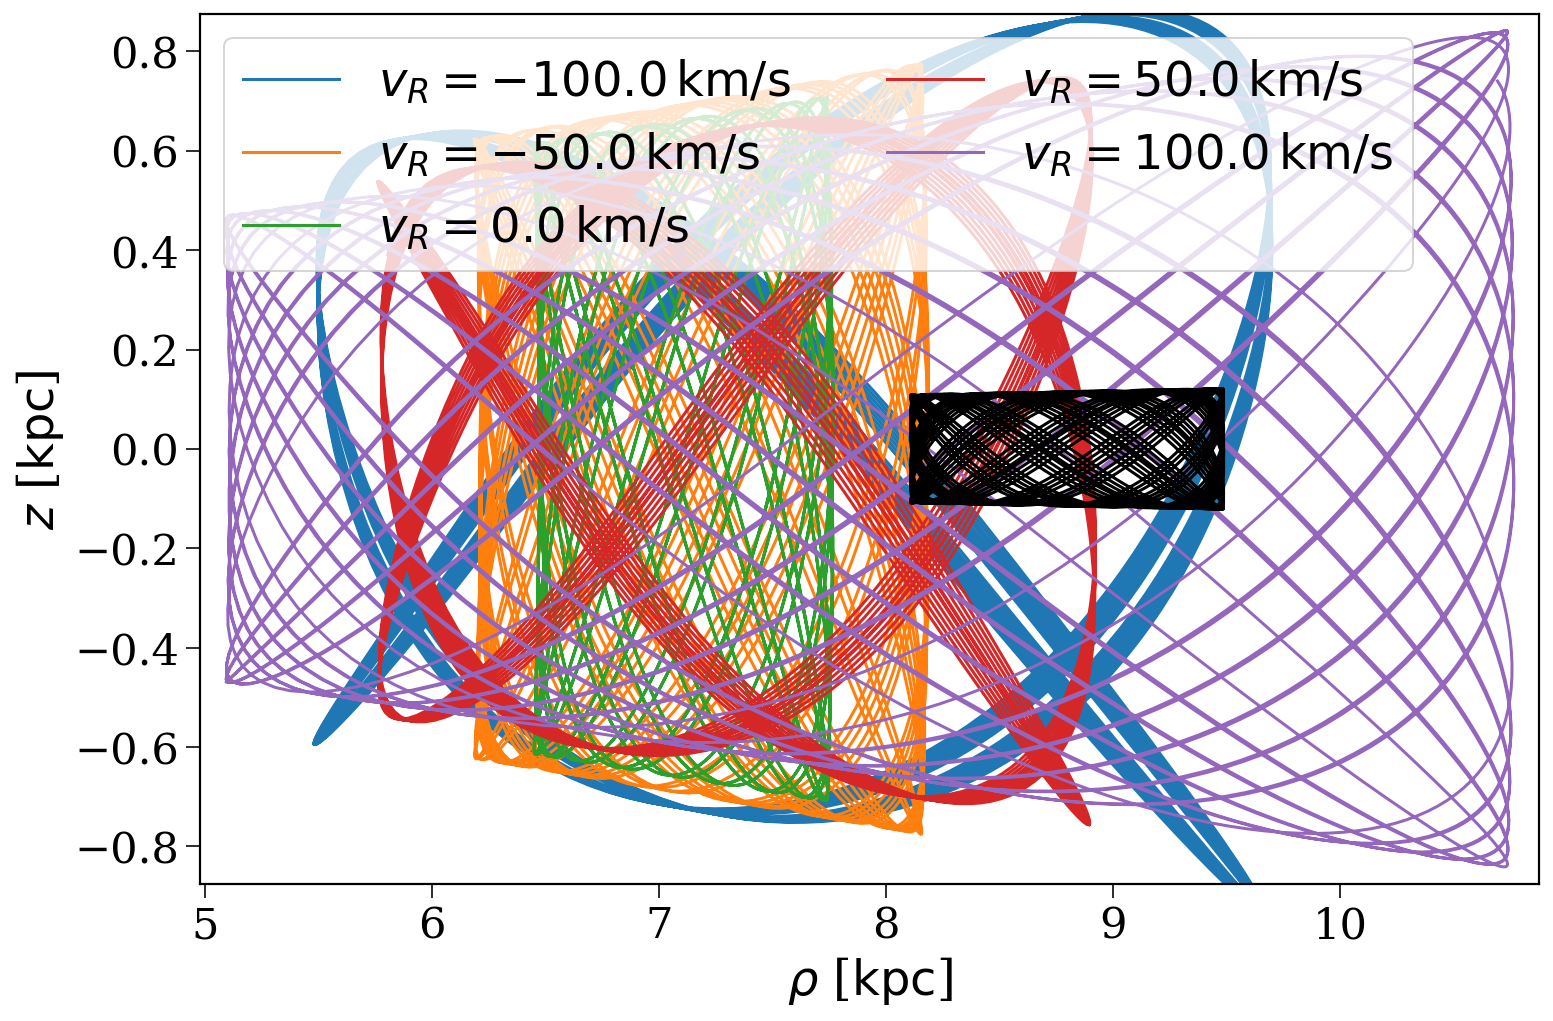

In [127]:
fig, ax = plt.subplots(figsize=(12, 8))

# plot the sun
_ = sun_orbit.cylindrical.plot(['rho', 'z'], axes=[ax], color='black', zorder=100)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plot the orbits with kicks

rvs = np.linspace(-100, 100, 5)
for i in range(no_kicks.shape[1]):
    _ = no_kicks[:, i].cylindrical.plot(['rho', 'z'], axes=[ax], label=r"$v_{{R}} = {{{}}} \, {{\rm km / s}}$".format(rvs[i]))
# _ = with_kicks.cylindrical.plot(['rho', 'z'], axes=[ax], color='tab:green')

plt.legend(ncol=2)

# overlay the kick positions
# with_kicks[0].cylindrical.plot(['rho', 'z'], axes=[ax], color='black', marker="^", s=100, zorder=100)
# for t in kick_times:
#     ind = np.where(with_kicks.t < t)[0][-1]
#     with_kicks[ind].cylindrical.plot(['rho', 'z'], axes=[ax], color='black', s=100, zorder=100)

ax.set_xlim(min(ax.get_xlim()[0], xlim[0]), max(ax.get_xlim()[1], xlim[1]))
ax.set_ylim(min(ax.get_ylim()[0], ylim[0]), max(ax.get_ylim()[1], ylim[1]))

plt.show()